# Census Data Frame

In [17]:
import pandas as pd
import numpy as np
import seaborn as sb
import dask.dataframe as dd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
age_data_df = pd.read_csv("age-census2021-ts007-msoa.csv")
age_data_df = age_data_df.drop('date',axis=1)
age_data_df = age_data_df.drop('geography',axis=1)
age_data_df = age_data_df.drop('Age: Total; measures: Value',axis=1)
age_data_df = age_data_df.set_index('geography code')
age_data_df = age_data_df[age_data_df.columns.drop(list(age_data_df.filter(regex='to')))]  # drop Age 5 - 9 years of values (aggregated values)
age_data_df = age_data_df[age_data_df.columns.drop(list(age_data_df.filter(regex='under')))]  # drop under Age 5 - 9 years of values (aggregated values)
## AVERAGE AGE

census_list = age_data_df.values.tolist()
list_of_ages = list(range(0, 101))
average_age = []
for geography in census_list:
    total = sum([x*y for x,y in zip(geography,list_of_ages)])
    average_age.append(total/sum(geography))
    
final_census_dataframe = pd.DataFrame(index=age_data_df.index)
final_census_dataframe['Average Age'] = average_age

In [22]:
## Unemployment Rate

unemployment_data_df = pd.read_csv("unemployment-census2021-ts066-msoa.csv")
unemployment_data_df = unemployment_data_df.drop('date',axis=1)
unemployment_data_df = unemployment_data_df.drop('geography',axis=1)
unemployment_data_df = unemployment_data_df.set_index('geography code')
unemployment_data_df = unemployment_data_df.drop(unemployment_data_df.columns.difference(['Economic activity status: Total: All usual residents aged 16 years and over','Economic activity status: Economically active (excluding full-time students)',"Economic activity status: Economically active (excluding full-time students): Unemployed"]), axis=1)

unemployment_data_df["Unemployment Rate"] = unemployment_data_df["Economic activity status: Economically active (excluding full-time students): Unemployed"]/unemployment_data_df["Economic activity status: Total: All usual residents aged 16 years and over"]
unemployment_data_df["Unemployment Rate (ex. Full-time Students)"] = unemployment_data_df["Economic activity status: Economically active (excluding full-time students): Unemployed"]/unemployment_data_df["Economic activity status: Economically active (excluding full-time students)"]

final_census_dataframe = pd.merge(final_census_dataframe, unemployment_data_df["Unemployment Rate (ex. Full-time Students)"], left_index=True, right_index=True)
final_census_dataframe = final_census_dataframe.sort_index(ascending=True)

In [23]:
## Transportation method

transport_data_df = pd.read_csv("transport-census2021-ts061-msoa.csv")
transport_data_df = transport_data_df.drop('date',axis=1)
transport_data_df = transport_data_df.drop('geography',axis=1)
transport_data_df = transport_data_df.set_index('geography code')

transport_data_df['Public transport'] = transport_data_df['Method of travel to workplace: Underground, metro, light rail, tram']+transport_data_df['Method of travel to workplace: Train']+transport_data_df['Method of travel to workplace: Bus, minibus or coach']
transport_data_df = transport_data_df.drop(['Method of travel to workplace: Underground, metro, light rail, tram','Method of travel to workplace: Train','Method of travel to workplace: Bus, minibus or coach','Method of travel to workplace: Taxi'],axis=1)
transport_data_df['In a car, van or motorcycle'] = transport_data_df['Method of travel to workplace: Driving a car or van']+transport_data_df['Method of travel to workplace: Passenger in a car or van']+transport_data_df['Method of travel to workplace: Motorcycle, scooter or moped']
transport_data_df = transport_data_df.drop(['Method of travel to workplace: Driving a car or van','Method of travel to workplace: Motorcycle, scooter or moped','Method of travel to workplace: Passenger in a car or van','Method of travel to workplace: Other method of travel to work'],axis=1)
transport_data_df['Bike or Foot'] = transport_data_df['Method of travel to workplace: Bicycle']+transport_data_df['Method of travel to workplace: On foot']
transport_data_df = transport_data_df.drop(['Method of travel to workplace: On foot','Method of travel to workplace: Bicycle'],axis=1)
transport_data_df.rename(columns = {'Method of travel to workplace: Work mainly at or from home':'Work from home'}, inplace = True)


transport_data_df.rename(columns = {'Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census':'Total'}, inplace=True)

In [24]:
## Population density

area_sizes_df = pd.read_csv("MSOA_(Dec_2001)_Boundaries_EW_BFC.csv")
area_sizes_df = area_sizes_df.drop(['Shape__Length','GlobalID','OBJECTID'],axis=1)
area_sizes_df.set_index('MSOA01CD',inplace=True)

age_data_for_population_df = pd.read_csv("age-census2021-ts007-msoa.csv")
age_data_for_population_df.set_index('geography code',inplace=True)
age_data_for_population_df = age_data_for_population_df[['Age: Total; measures: Value']]

area_sizes_df = pd.merge(area_sizes_df, age_data_for_population_df, left_index=True, right_index=True)
area_sizes_df['Shape__Area'] /= 1000000  # change from m2 to km2
area_sizes_df['Population density'] = area_sizes_df['Age: Total; measures: Value']/area_sizes_df['Shape__Area']

final_area_sizes_df = area_sizes_df[['Population density']]

In [25]:
## income 

income_df = pd.read_csv("IncomeLevels.csv", sep = ';')
income_df.set_index('MSOA code',inplace=True)
final_income_df = income_df[['Net annual income (£)']]
final_income_df['Net annual income (£)'] = final_income_df['Net annual income (£)'].str.replace(" ", "")
final_income_df['Net annual income (£)'] = pd.to_numeric(final_income_df['Net annual income (£)'])

In [26]:
transport_data_df['Work from home rate'] = transport_data_df['Work from home']/transport_data_df['Total']
transport_data_df['Commute by public transport rate'] = transport_data_df['Public transport']/transport_data_df['Total']
transport_data_df['Commute in a car, van or motorcycle'] = transport_data_df['In a car, van or motorcycle']/transport_data_df['Total']
transport_data_df['Commute by walking or cycling'] = transport_data_df['Bike or Foot']/transport_data_df['Total']

final_census_dataframe = pd.merge(final_census_dataframe, transport_data_df['Work from home rate'], left_index=True, right_index=True)
final_census_dataframe = pd.merge(final_census_dataframe, transport_data_df['Commute by public transport rate'], left_index=True, right_index=True)
final_census_dataframe = pd.merge(final_census_dataframe, transport_data_df['Commute in a car, van or motorcycle'], left_index=True, right_index=True)
final_census_dataframe = pd.merge(final_census_dataframe, transport_data_df['Commute by walking or cycling'], left_index=True, right_index=True)

final_census_dataframe = pd.merge(final_census_dataframe, final_area_sizes_df, left_index=True, right_index=True,how='outer')
final_census_dataframe = pd.merge(final_census_dataframe, final_income_df, left_index=True, right_index=True,how='outer')

,Average Age,Unemployment Rate (ex. Full-time Students),Work from home rate,Population density,Net annual income (£)
E02000001,40.545055,0.050765,0.673019,2960.492387,47200.0
E02000002,34.540800,0.082277,0.209389,3831.018109,32200.0
E02000003,35.646803,0.071789,0.255059,5392.439728,37800.0
E02000004,39.271596,0.069008,0.250803,2663.912033,35300.0
E02000005,32.839906,0.064049,0.220485,9332.013766,37800.0
...,...,...,...,...,...
W02000424,48.679675,0.025349,0.284608,NaN,NaN
W02000425,43.015702,0.044097,0.341750,NaN,NaN
W02000426,45.446865,0.038187,0.167120,NaN,NaN
W02000427,43.031057,0.055183,0.177668,NaN,NaN


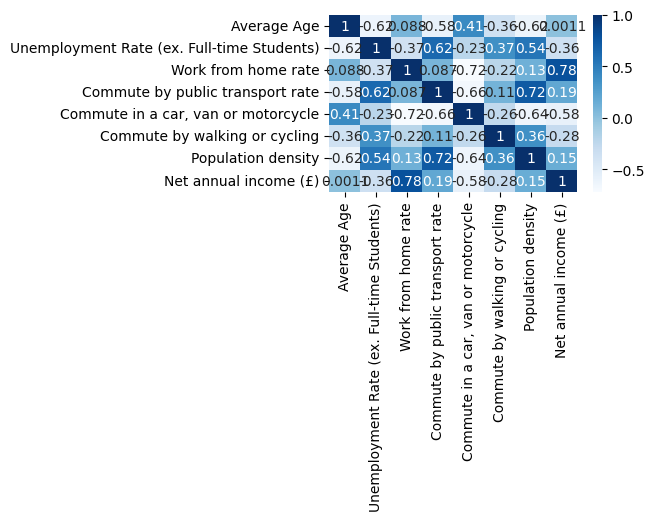

In [27]:
heat_map = final_census_dataframe[~final_census_dataframe.index.str.startswith('W')].corr()#['Net annual income (£)'].quantile([.25, .5, .75])
sb.heatmap(heat_map, cmap="Blues", annot=True)
final_census_dataframe.drop(['Commute by public transport rate','Commute by walking or cycling','Commute in a car, van or motorcycle'],axis=1)

# Response Data Frame

In [33]:
#data = pd.read_csv("Vendors' preference of payment methods.csv")
data = pd.read_csv('Vendorsdata.csv',sep=';')

In [ ]:
"""
Do not run! This cell is used to remove the many subindustry columns and merge them into a single one
"""

# source subindustries
columnNames = ['Which sub-industry do you mainly operate in?','Which sub-industry do you mainly operate in?.1','What field does your business operate in?','Which sub-industry do you mainkly operate in?','Which sub-industry do you mainly operate in?.2','What field do you operate in?','What sub-industry do you manufactore in?']
numberOfNaN = data[columnNames].isnull().values
subIndustries = []
index = 0
for entry in numberOfNaN:
    if (np.size(entry) - np.count_nonzero(entry) > 1): # sanity check, max 1 subindustry, i.e. max 1 False
        print(f'The entry number {index} has more than one sub-industry. Stopping all further operations.')
        exit()
    elif (np.size(entry) - np.count_nonzero(entry) == 1):
        subIndustryIndex = (np.where(entry == 0)[0])[0]
        column = columnNames[subIndustryIndex]
        subIndustries.append(data.loc[index][column])
    else:
        column = 'What is the sector you operate in?'  # newly defined subindustry
        subIndustries.append(data.loc[index][column])
    index += 1
    
# remove sub industries column
data = data.drop(columnNames,axis=1)
if (len(data)!=len(subIndustries)):
    print(f'Count miss-match, entries count: {len(data)} while sub-industries list count: {len(subIndustries)}')
data.insert(5,'Subindustry',subIndustries)

In [12]:
"""
Do not run! This cell is used to modify the postcodes, copy entries with multiple postcodes and correct the postcodes to the correct format
"""

## copy multiple postcodes entry
postcodes = [x.split(";") for x in data['What is the postcode of the business? (Again if multiple postcodes, separate them by semicolon)']]
indicesOfMultiPostcodes =  [i for i, x in enumerate(postcodes) if len(x) > 1]
numberOfPostcodes = [len(x) for i, x in enumerate(postcodes) if len(x) > 1]
#print(postcodes)
#print(indicesOfMultiPostcodes)
#print(numberOfPostcodes)

multiplier = {indicesOfMultiPostcodes[i]: numberOfPostcodes[i] for i in range(len(indicesOfMultiPostcodes))}
df2 = data.iloc[indicesOfMultiPostcodes,:]
df2 = df2.loc[df2.index.repeat(df2.index.map(multiplier))]



In [34]:
"""
This cell is used to rename the column names from the original names sourced from the form to a shorter coded names used for the statistics purposes
"""
data.set_index('Column1',inplace=True)
oldColumns = list(data.columns.values)
newColumns = ["Timestamp","Name","Address","Postcode","Industry","Subindustry","Accepted_payment_methods","Most_used_method","Preferred_method"]
newColumnsDict = {oldColumns[i]: newColumns[i] for i in range(len(oldColumns))}
data = data.rename(columns=newColumnsDict)

In [35]:
# Do accept Cash
data2 = data.copy()

if 'AcceptingCashBinary' not in data2:
    data2['AcceptingCashBinary'] = data2['Accepted_payment_methods'].str.contains('Cash').astype(int)
    # Do accept Card
    data2['AcceptingCardBinary'] = data2['Accepted_payment_methods'].str.contains('Card').astype(int)

if 'MostUsedContactlessBinary' not in data2:
    # Is most used method contactless
    data2['MostUsedContactlessBinary'] = data2['Most_used_method'].str.contains('Contactless').astype(int)
    # Is most used method debit
    data2['MostUsedDebitBinary'] = data2['Most_used_method'].str.contains('Debit').astype(int)
    # Is most used method credit
    data2['MostUsedCreditBinary'] = data2['Most_used_method'].str.contains('Credit').astype(int)
    # Is most used method cash
    data2['MostUsedCashBinary'] = data2['Most_used_method'].str.contains('Cash').astype(int)


# Is preferred method debit
data2['PreferredDebitBinary'] = data2['Preferred_method'].str.contains('Debit|Contactless').astype(int)
# Is preferred method credit
data2['PreferredCreditBinary'] = data2['Preferred_method'].str.contains('Credit').astype(int)
# Is preferred method something else
data2.loc[(data2['PreferredCreditBinary'] == 1) | (data2['PreferredDebitBinary'] == 1), 'PreferredCashBinary'] = False
data2['PreferredCashBinary'] = data2['PreferredCashBinary'].fillna(True).astype(int)

collected_data_df = data2.copy()

In [15]:
"Do not run!"
filename = "PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU2.csv"
converting_df = dd.read_csv(filename, encoding = 'ISO-8859-1',dtype=str)

postcodes = list(collected_data_df["Postcode"])
i = 0
for postcode in postcodes:
    postcode = postcode.upper()
    postcode = postcode.replace(" ", "")
    if len(postcode) == 5:
        postcode = postcode[0:2] + ' ' + postcode[2:]
    elif len(postcode) == 6:
        postcode = postcode[0:3] + ' ' + postcode[3:]
    elif len(postcode) == 7:
        postcode = postcode[0:4] + ' ' + postcode[4:]
    postcodes[i] = postcode
    i += 1
    
outputareas = []
for postcode in postcodes:
    entry = converting_df[converting_df['pcds'] == postcode]
    output_area = entry['msoa11cd'].compute().tolist()
    if len(output_area) != 0:
        outputareas.append(output_area[0])
    else:
        outputareas.append(np.nan)

collected_data_df.insert(loc = 4,column = 'OutputArea',value = outputareas)

In [36]:
collected_data_df

,Timestamp,Name,Address,Postcode,Industry,Subindustry,Accepted_payment_methods,Most_used_method,Preferred_method,AcceptingCashBinary,AcceptingCardBinary,MostUsedContactlessBinary,MostUsedDebitBinary,MostUsedCreditBinary,MostUsedCashBinary,PreferredDebitBinary,PreferredCreditBinary,PreferredCashBinary
Column1,,,,,,,,,,,,,,,,,,
E02003790,NaN,The Three Hills,"Bartlow Rd, Cambridge CB21 4PW, United Kingdom",CB21 4PW,Hospitality,Bar,"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,1,0,1,0,0,1,0,0
E02004575,NaN,East of England Co-op Food,"Riverside Ave E, Manningtree CO11 1US, United ...",CO11 1US,Consumer Goods,Supermarket,"Debit Card, Credit Card",Debit Card,Debit Card,0,1,0,1,0,0,1,0,0
E02006504,NaN,Blue Bell Cider House,"Warings Green Rd, Earlswood, Solihull B94 6BP,...",B94 6BP,Hospitality,Pub,"Cash, Debit Card, Credit Card",Debit Card,Credit Card,1,1,0,1,0,0,0,1,0
E02006766,NaN,Kemerton Coffee House,"High St, Tewkesbury GL20 7HP, United Kingdom",GL20 7HP,Hospitality,Coffee Related,"Cash, Debit Card, Credit Card",Debit Card,Cash,1,1,0,1,0,0,0,0,1
E02000978,NaN,Tomtom Coffee House,"114 Ebury St, London SW1W 9NZ, United Kingdom",SW1W 9NZ,Hospitality,Coffee Related,"Cash, Debit Card, Credit Card",Contactless,Debit Card,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000809,NaN,WatchHouse Bermondsey,"199 Bermondsey St, London SE1 3UW, United Kingdom",SE1 3UW,Hospitality,Coffee Related,"Debit Card, Credit Card",Debit Card,Debit Card,0,1,0,1,0,0,1,0,0
E02000809,NaN,Restaurant Story,"199 Tooley St, London SE1 2JX, United Kingdom",SE1 2JX,Hospitality,Restaurant (Dine-in),"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,1,0,1,0,0,1,0,0
E02000809,NaN,Butlers Wharf Chop House,"36e Shad Thames, London SE1 2PJ, United Kingdom",SE1 2PJ,Hospitality,Restaurant (Dine-in),"Cash, Debit Card, Credit Card",Credit Card,Debit Card,1,1,0,0,1,0,1,0,0


# Joining them together

In [37]:
final_data = pd.merge(collected_data_df, final_census_dataframe, left_index=True, right_index=True)
final_data

,Timestamp,Name,Address,Postcode,Industry,Subindustry,Accepted_payment_methods,Most_used_method,Preferred_method,AcceptingCashBinary,...,PreferredCreditBinary,PreferredCashBinary,Average Age,Unemployment Rate (ex. Full-time Students),Work from home rate,Commute by public transport rate,"Commute in a car, van or motorcycle",Commute by walking or cycling,Population density,Net annual income (£)
E02000001,NaN,London Silver Vaults,"53-64 Chancery Ln, London , United Kingdom",WC2A 1QS,Consumer Goods,Specialest Store,"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,...,0,0,40.545055,0.050765,0.673019,0.107623,0.028027,0.177317,2960.492387,47200.0
E02000001,NaN,Savage Garden,"Floor 12, 7 Pepys St, London EC3N 4AF, United ...",EC3N 4AF,Hospitality,Bar,"Cash, Debit Card, Credit Card",Contactless,Cash,1,...,0,1,40.545055,0.050765,0.673019,0.107623,0.028027,0.177317,2960.492387,47200.0
E02000001,NaN,Rake’s Café Bar,"40 Liverpool St, London EC2M 7QN, United Kingdom",EC2M 7QN,Hospitality,Bar,"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,...,0,0,40.545055,0.050765,0.673019,0.107623,0.028027,0.177317,2960.492387,47200.0
E02000001,NaN,Rosslyn Coffee Queen Victoria Street,"78 Queen Victoria St, London EC4N 4SJ, United ...",EC4N 4SJ,Hospitality,Coffee Related,"Debit Card, Credit Card",Debit Card,Cash,0,...,0,1,40.545055,0.050765,0.673019,0.107623,0.028027,0.177317,2960.492387,47200.0
E02000001,NaN,Curators Coffee Studio,"9A Cullum St, London EC3M 7JJ, United Kingdom",EC3M 7JJ,Hospitality,Coffee Related,"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,...,0,0,40.545055,0.050765,0.673019,0.107623,0.028027,0.177317,2960.492387,47200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02006912,NaN,Takk,"6 Tariff St, Manchester M1 2FF, United Kingdom",M1 2FF,Hospitality,Coffee Related,"Cash, Debit Card, Credit Card",Debit Card,Credit Card,1,...,1,0,29.620459,0.041380,0.544796,0.105237,0.149209,0.188900,NaN,33300.0
E02006912,NaN,Moose Coffee,8a Gateway House Station Approach Piccadilly S...,M1 2GH,Hospitality,Coffee Related,"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,...,0,0,29.620459,0.041380,0.544796,0.105237,0.149209,0.188900,NaN,33300.0
E02006912,NaN,easyHotel Manchester City Centre,"33 Dale St, Manchester M1 2HF, United Kingdom",M1 2HF,Hospitality,Hotel,"Cash, Debit Card, Credit Card",Debit Card,Debit Card,1,...,0,0,29.620459,0.041380,0.544796,0.105237,0.149209,0.188900,NaN,33300.0
E02006912,NaN,Manchester Piccadilly Hotel,"London Rd, Manchester M1 2PG, United Kingdom",M1 2PG,Hospitality,Hotel,"Cash, Debit Card, Credit Card",Credit Card,Debit Card,1,...,0,0,29.620459,0.041380,0.544796,0.105237,0.149209,0.188900,NaN,33300.0


# Logistic regression models

In [38]:
from sklearn.utils import resample
def bootstrapping(fii, X,y):
    coefs = fii.coef_[0]
    n_bootstraps = 1000
    bootstrapped_ci = []
    X_vals = np.linspace(min(X), max(X), 100)
    
    # Perform bootstrapping to get the confidence intervals
    for i in range(n_bootstraps):
        X_resampled, y_resampled = resample(X.reshape(-1, 1), y)
        logreg_resampled = LogisticRegression()
        logreg_resampled.fit(X_resampled, y_resampled)
        y_resampled_vals = logreg_resampled.predict_proba(X_vals)[:, 1]
        bootstrapped_ci.append(y_resampled_vals)

    # Calculate lower and upper bounds of the intervals
    lower_bound = np.percentile(bootstrapped_ci, 2.5, axis=0)
    upper_bound = np.percentile(bootstrapped_ci, 97.5, axis=0)
    return (lower_bound, upper_bound)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import statsmodels.api as sm
from scipy.special import expit
import scipy
import seaborn as sns

Optimization terminated successfully.
         Current function value: 0.427815
         Iterations 6


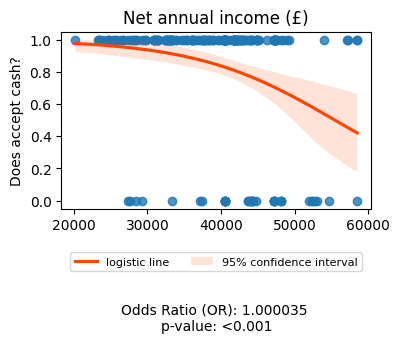


 Coefficient: 3.4814860871079916e-05 Intercept: 1.5600724590389503e-09

 Odds Ratio (OR): 1.000035 
 p-values: <0.001
Optimization terminated successfully.
         Current function value: 0.184129
         Iterations 8


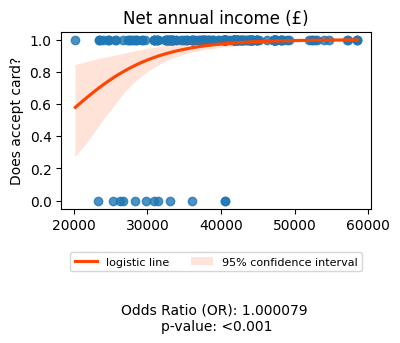


 Coefficient: 7.854285150041181e-05 Intercept: 4.643774128034779e-10

 Odds Ratio (OR): 1.000079 
 p-values: <0.001
Optimization terminated successfully.
         Current function value: 0.391024
         Iterations 6


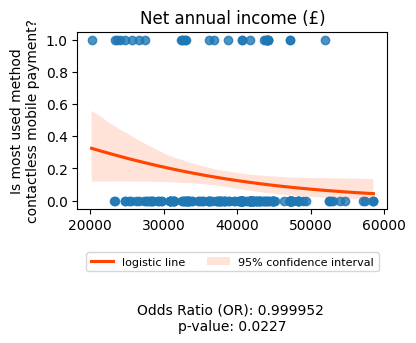


 Coefficient: -4.820668087546722e-05 Intercept: -1.116102093747398e-09

 Odds Ratio (OR): 0.999952 
 p-values: 0.0227
Optimization terminated successfully.
         Current function value: 0.604384
         Iterations 5


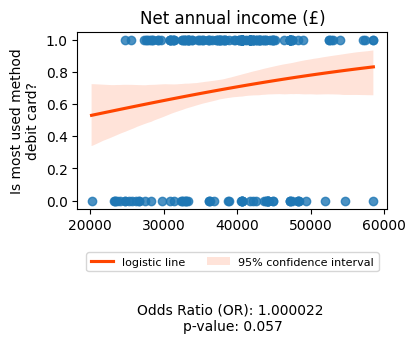


 Coefficient: 2.2037847297325603e-05 Intercept: 4.6437722841585226e-10

 Odds Ratio (OR): 1.000022 
 p-values: 0.057
Optimization terminated successfully.
         Current function value: 0.282349
         Iterations 7


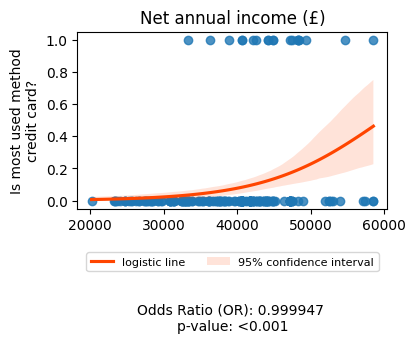


 Coefficient: -5.267306269912169e-05 Intercept: -2.9913896709929914e-09

 Odds Ratio (OR): 0.999947 
 p-values: <0.001
Optimization terminated successfully.
         Current function value: 0.641728
         Iterations 4


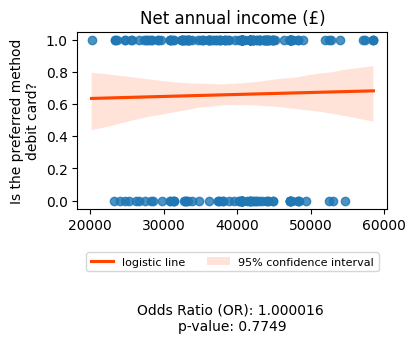


 Coefficient: 1.6421615745357514e-05 Intercept: 4.4553531752358e-10

 Odds Ratio (OR): 1.000016 
 p-values: 0.7749
Optimization terminated successfully.
         Current function value: 0.258409
         Iterations 7


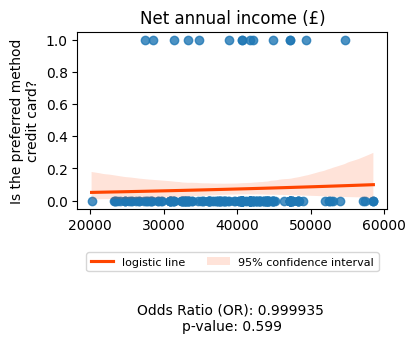


 Coefficient: -6.45466692660838e-05 Intercept: -2.364481945843577e-09

 Odds Ratio (OR): 0.999935 
 p-values: 0.599
Optimization terminated successfully.
         Current function value: 0.581590
         Iterations 5


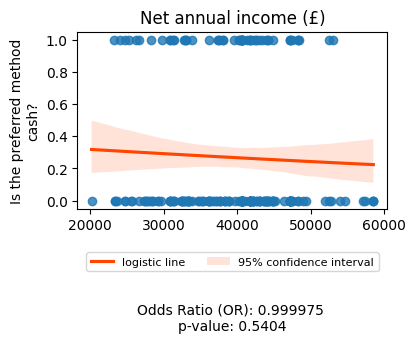


 Coefficient: -2.5214889773967043e-05 Intercept: -6.922377880723681e-10

 Odds Ratio (OR): 0.999975 
 p-values: 0.5404










In [42]:
X_names = ['Average Age','Unemployment Rate (ex. Full-time Students)', 'Work from home rate', 'Commute by public transport rate', 'Commute in a car, van or motorcycle', 'Commute by walking or cycling', 'Population density', 'Net annual income (£)']
X_names= ['Average Age','Unemployment Rate (ex. Full-time Students)', 'Work from home rate', 'Commute by public transport rate', 'Net annual income (£)', 'Population density']

X_names = ['Net annual income (£)']
y_names = ['AcceptingCashBinary', 'AcceptingCardBinary', 'MostUsedContactlessBinary', 'MostUsedDebitBinary', 'MostUsedCreditBinary','PreferredDebitBinary','PreferredCreditBinary','PreferredCashBinary']
y_labels = ['Does accept cash?', 'Does accept card?', 'Is most used method\ncontactless mobile payment?', 'Is most used method\ndebit card?', 'Is most used method\ncredit card?','Is the preferred method\ndebit card?','Is the preferred method\ncredit card?','Is the preferred method\ncash?']
#y_names = ['PreferredDebitBinary','PreferredCreditBinary','PreferredCashBinary']
#y_labels = ['Is the preferred method\ndebit card?','Is the preferred method\ncredit card?','Is the preferred\nmethod cash?']
#y_names = ['MostUsedContactlessBinary']
#y_labels = ['Is most used method\ncontactless mobile payment?']


plt.rcParams['figure.figsize'] = [4, 2.3]
for x_var in X_names:
    final_data_copy = final_data.copy()
    final_data_copy = final_data_copy[final_data_copy[x_var].notna()]
    label_i = 0
    for y_var in y_names:
        y = final_data_copy[y_var].values
        X = final_data_copy[x_var].values.reshape(-1,1)
        
        # fit the logistic regression model to the training data
        clf = LogisticRegression()
        X_train, y_train = X,y
        clf.fit(X_train, y_train)        
        # Get p-values
        X_train_sm = X_train.copy()
        X_train_sm = sm.add_constant(X_train_sm)
        mod = sm.Logit(y_train,X_train_sm)
        fii = mod.fit()
        p_values = fii.pvalues[1]
        if p_values > 0.00098:
            p_values = p_values.round(4)
        else:
            p_values = "<0.001"
        
        lower_bound, upper_bound = bootstrapping(clf,X,y)
        odds_ratio = np.exp(clf.coef_)[0][0]
        odds_ratio = round(odds_ratio,6)
        # if a>1:
        #     odds_ratio = 1.01
        # else:
        #     odds_ratio = 0.99
        
        #Using sns to display charts
        
        mydataset = pd.DataFrame({x_var:final_data_copy[x_var].values, y_var:final_data_copy[y_var].values})
        fig = plt.figure(figsize=(4,2.3))
        ax = sns.regplot(x=x_var, y=y_var, data=mydataset, logistic=True, scatter_kws={"color": "#1f77b4"}, line_kws={"color": "orangered","label":"logistic line"})
        ax.collections[1].set_label('95% confidence interval')
        ax.legend(bbox_to_anchor=(0.5, -0.3), loc='center', ncol=2,fontsize=8, title_fontsize=11)
        #fig.legend(bbox_to_anchor=(0.5, -0.13), loc='center', ncol=2,fontsize=8, title_fontsize=11)
        plt.title(x_var)
        plt.xlabel(f"\n\n\n\nOdds Ratio (OR): {odds_ratio} \np-value: {p_values}")
        plt.ylabel(y_labels[label_i])
        #fig.savefig(str(x_var[:12])+"_"+str(y_var),dpi=500,bbox_inches='tight')
        plt.show()
        
        label_i += 1
        print(f"\n Coefficient: {clf.coef_[0][0]} Intercept: {clf.intercept_[0]}\n\n Odds Ratio (OR): {odds_ratio} \n p-values: {p_values}")
    
    print("\n\n\n\n\n\n\n")

In [43]:
from statsmodels.api import Logit

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

final_data2 = final_data.copy()
final_data2 = final_data2.drop(['Timestamp','Preferred_method'],axis=1)
final_data2 = final_data2.dropna()


X = final_data2[['Average Age', 'Work from home rate', 'Commute by public transport rate', 'Commute in a car, van or motorcycle', 'Commute by walking or cycling']] # input features matrix (shape: (n_samples, n_features))
X = final_data2[['Average Age','Unemployment Rate (ex. Full-time Students)','Work from home rate', 'Commute by public transport rate', 'Commute in a car, van or motorcycle', 'Commute by walking or cycling','Population density', 'Net annual income (£)']]
#X = final_data2[['Work from home rate', 'Commute by public transport rate', 'Commute in a car, van or motorcycle', 'Commute by walking or cycling', 'Net annual income (£)']]
y = final_data2['AcceptingCashBinary'] # target variable (shape: (n_samples,))
#y = final_data['AcceptingCashBinary']

# split data into training and test sets
X_train, y_train = X,y


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit


num_class_0 = sum(y_train == 0)
num_class_1 = sum(y_train == 1)

# Calculate the weight for each observation
# weights = np.zeros(len(y_train))
# weights[y_train == 0] = num_class_1 / (num_class_0 + num_class_1)
# weights[y_train == 1] = num_class_0 / (num_class_0 + num_class_1)

# Fit the logistic regression model
logit = Logit(y_train, sm.add_constant(X_train))
logit_balanced = logit.fit(method="bfgs",disp=0,maxiter=100)
logit_model = logit_balanced
# fit the logistic regression model using statsmodel library

print("\n\n\n\n")
# get McFadden's Pseudo R-squared
mcfadden_r2 = 1 - logit_model.llf/logit_model.llnull
print('McFadden\'s Pseudo R-squared:', mcfadden_r2)

mcfadden_r2 = logit_model.prsquared
print("McFadden pseudo R-squared: ", mcfadden_r2)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import  summary_table
# fit the reduced model

#X_train = X_train.values

from statsmodels.iolib.summary2 import summary_col

# fit the reduced model
X_reduced = X_train[['Net annual income (£)','Unemployment Rate (ex. Full-time Students)']]
reduced_model = Logit(y_train, sm.add_constant(X_reduced)).fit()

# compare the reduced model with the full model
res_reduced_model = reduced_model.summary2()
res_logit_model = logit_model.summary2()

print(res_reduced_model)
print(res_logit_model)

#results = summary_col([res_reduced_model, res_logit_model],stars=True,float_format='%0.3f', model_names=['Reduced', 'Full'], info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),'R2':lambda x: "{:.2f}".format(x.prsquared)})
#print(results)






McFadden's Pseudo R-squared: 0.20914459668141905
McFadden pseudo R-squared:  0.20914459668141905
Optimization terminated successfully.
         Current function value: 0.383542
         Iterations 8
                                      Results: Logit
Model:                       Logit                      Pseudo R-squared:        0.204     
Dependent Variable:          AcceptingCashBinary        AIC:                     149.4445  
Date:                        2023-03-07 11:28           BIC:                     159.1379  
No. Observations:            187                        Log-Likelihood:          -71.722   
Df Model:                    2                          LL-Null:                 -90.150   
Df Residuals:                184                        LLR p-value:             9.9268e-09
Converged:                   1.0000                     Scale:                   1.0000    
No. Iterations:              8.0000                                                        
-------

C:\Users\samue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\samue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\samue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\samue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by ze